##Подготовка

###Импорт и установка библиотек

In [ ]:
# Установка pydicom
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# Модель
from tensorflow.keras import Model, Input

# Слои
from tensorflow.keras.layers import Conv3D, BatchNormalization, Activation
from tensorflow.keras.layers import MaxPooling3D, Conv3DTranspose, concatenate

# Оптимизатор
from keras.optimizers import Adam

# Схема модели
from tensorflow.keras.utils import plot_model

# Для низкоуровневого доступа к операциям и тензорам
import tensorflow.keras.backend as K

# Для работы с изображениями
from PIL import Image

# Для работы с dcm-изображениями
import pydicom as dicom

# Для работы с nii-изображениями
import nibabel as nib

# Инструменты для работы с массивами
import numpy as np

# Для уменьшения размеров изображений в numpy
from scipy.ndimage import zoom

# Для работы с файлами
import os, shutil
from google.colab import drive

# Для работы с датой/временем
import datetime

# очистка ОЗУ
import gc

# Игнорирование предупреждений
import warnings

# Отрисовка графиков
import matplotlib.pyplot as plt

%matplotlib inline

###Глобальные параметры

In [ ]:
IMG_RESOLUTION = 32                                             # Разрешение картинки
DATA_DIR = os.path.join(os.sep, 'content', 'data')              # Папка с данными
CLASS_COUNT = 1                                                 # Количество классов (с выпотом и без, бинарная сегментация)
MIN_BOUND = 0                                                   # Минимальная граница расположения выпота
MAX_BOUND = 400                                                 # Максимальная граница расположения выпота
MAX_SLICES = 304                                                # Максимальное количество срезов
GDRIVE_PATH = os.path.join(os.sep, 'content', 'drive')          # Путь монтирования Google Disk
DRIVE_DATA_DIR = os.path.join('MyDrive', 'Colab Notebooks',     # Путь к датасетам на Google Disk
                              'УИИ', 'Стажировка',
                              '2. Radlogics', 'data')
BATCH_SIZE = 1                                                  # размер батча
SIZE_STEP = BATCH_SIZE                                          # шаг смещения

# Данные из ноутбука Experiments
MIN_SLICES = 75                                                 # Минимальное количество срезов
FIRST_EFF_SLICE_NUM = 0                                         # Номер первого среза на весь датасет, где присутствует выпот 
LAST_EFF_SLICE_NUM = 160                                        # Номер последнего среза на весь датасет, где присутствует выпот
MIN_DCM = -1024                                                 # Минимальное значение пикселя в файлах DICOM
MAX_DCM = 4095                                                  # Максимальное значение пикселя в файлах DICOM

# Пути к папкам с оригинальными изображениями и плевральными масками
original_dir = os.path.join(DATA_DIR, 'Original')               # Папка с оригинальными DICOM файлами
effusions_dir = os.path.join(DATA_DIR, 'Effusions')             # Папка с файлами плевральных выпотов
thor_cav_dir = os.path.join(DATA_DIR, 'Thoracic_Cavities')      # Папка с файлами грудных полостей

###Загрузка датасета

Скачиваем архивы и распаковываем в папку data, предварительно очистив её.

In [ ]:
# Очищаем папку с данными

if os.path.exists(DATA_DIR): shutil.rmtree(DATA_DIR)

In [ ]:
# Подключаем Google Drive

drive.mount(GDRIVE_PATH)

Mounted at /content/drive


In [ ]:
# Оригинальные сканы

original_zip = os.path.join(GDRIVE_PATH, DRIVE_DATA_DIR, 'Original.zip')
!unzip -qo "$original_zip" -d $DATA_DIR

#!gdown -q https://drive.google.com/uc?id=13Fm6vu45kkU8o85Lp2JVtItItIOJlovc
#!unzip -qo Original -d data

In [ ]:
# Датасет с масками выпотов

effusions_zip = os.path.join(GDRIVE_PATH, DRIVE_DATA_DIR, 'effusions_png.zip')
!unzip -qo "$effusions_zip" -d $DATA_DIR
#!gdown -qO PleThora_Effusions_June_2020.zip https://wiki.cancerimagingarchive.net/download/attachments/68551327/PleThora%20Effusions%20June%202020.zip?version=1&modificationDate=1593202778373&api=v2
#!unzip -qo PleThora_Effusions_June_2020 -d data

In [ ]:
# Датасет с масками грудных полостей
'''
!gdown -qO PleThora_Thoracic_Cavities_June_2020.zip https://wiki.cancerimagingarchive.net/download/attachments/68551327/PleThora%20Thoracic_Cavities%20June%202020.zip?version=1&modificationDate=1593202695428&api=v2
!unzip -qo PleThora_Thoracic_Cavities_June_2020 -d data'''

'\n!gdown -qO PleThora_Thoracic_Cavities_June_2020.zip https://wiki.cancerimagingarchive.net/download/attachments/68551327/PleThora%20Thoracic_Cavities%20June%202020.zip?version=1&modificationDate=1593202695428&api=v2\n!unzip -qo PleThora_Thoracic_Cavities_June_2020 -d data'

###Полезные функции


*   get_full_path(sub_path)
*   get_folders(path)
*   plot_pics(imgs, titles):

In [ ]:
# Функция получения пути к папке с изображениями, будь то:
# LUNG1-XXX;
# LUNG1-XXX/какая-то_папка
# LUNG1-XXX/какая-то_папка1/какая-то_папка2

def get_full_path(sub_path):  # sub_path - полный путь к папке LUNG1-XXX
    
    full_path = sub_path
    for _ in range(2):
        if os.path.exists(os.path.isdir(os.path.join(full_path, os.listdir(full_path)[0]))):
            path = os.path.join(full_path, os.listdir(full_path)[0])
        if os.path.isdir(path):
            full_path = path

    return full_path

In [ ]:
# Функция получения списка исключительно папок в определённой директории

def get_folders(path):                        # путь к папке с данными

    # Создаём список, содержащий только папки
    folders = []
    for item in os.listdir(path):             # список элементов в директории
        full_path = os.path.join(path, item)
        if os.path.isdir(full_path):
            folders.append(item)

    return folders

In [ ]:
# Функция для отображения двух изображений

def plot_pics(imgs, titles):

    num = len(imgs)
    plt.figure(1, figsize=(3*num, 3))

    for i in range(num):
        plt.subplot(1, num, i+1)
        plt.title(titles[i])
        plt.imshow(imgs[i], cmap='gray')
        plt.axis('off')

    plt.show()

##Сегментация плевральных выпотов

###Формирование train, val, test масок и выходного массива данных

После проведённого ряда экспериментов, связанных с ограничением памяти по формированию входного массива, принято решение формировать входные данные партиями и постепенно обучать модель.

Сформируем метки наличия выпотов `effusion_labels` для экземпляров (директорий) оригинальных 3D изображений путём сравнения наличия директорий `LUNG1-XXX` в папках `ORIGINAL_DIR` и `EFFUSIONS_DIR`.

Значения `effusion_labels`: 1 - выпот имеется; 0 - без выпота.

In [ ]:
# Получаем списки папок LUNG1-XXX и переводим их в numpy массив
orig_dir_np = np.array(sorted(get_folders(original_dir))) # папки с оригинальными изображениями
eff_dir_np = np.array(sorted(get_folders(effusions_dir))) # папки с плевральными выпотами

# Отфильтровываем директории в eff_dir_np, которых нет в orig_dir_np
eff_dir_np = eff_dir_np[np.in1d(eff_dir_np, orig_dir_np)]

# Создаём список меток через разницу папок в виде булевых значений и переводим в 0 и 1
effusion_labels = np.isin(orig_dir_np, eff_dir_np).astype(bool)

# Количество 3D-изображений лёгких (директорий LUNG1-XXX) - объём датасета 
orig_elements_count = len(orig_dir_np)

# Результат
print(orig_dir_np[:5])
print(eff_dir_np[:5])
print(effusion_labels[:5])
print(f'Всего лёгких с выпотом {np.sum(effusion_labels==1)} из {orig_elements_count} экземпляров.')

['LUNG1-001' 'LUNG1-002' 'LUNG1-004' 'LUNG1-005' 'LUNG1-006']
['LUNG1-001' 'LUNG1-002' 'LUNG1-005' 'LUNG1-008' 'LUNG1-013']
[ True  True False  True False]
Всего лёгких с выпотом 77 из 402 экземпляров.


Получим маски для обучающей, проверочной и тестовой выборок на весь объём данных с пропорциональным разделением на лёгкие с плевральным выпотом и без него для каждого набора.

In [ ]:
# Функция для сохранения масок выборок в файл

def save_masks(train, val, test):

    with open(os.path.join(GDRIVE_PATH, DRIVE_DATA_DIR, 'NetParameters.txt'), mode="a") as file:
        # получаем текущее время
        current_time = datetime.datetime.now()
        
        # записываем дату и время
        file.write(f'Произведено: {current_time}')

        # записываем маски
        file.write(f'\nМаска для обучающей выборки:\n')
        file.write(' '.join(map(str, train.astype(np.byte))))
        file.write(f'\nМаска для проверочной выборки:\n')
        file.write(' '.join(map(str, val.astype(np.byte))))
        file.write(f'\nМаска для тестовой выборки:\n')
        file.write(' '.join(map(str, test.astype(np.byte))) + '\n')

In [ ]:
# Функция для вывода результата разделения выборок

def split_results(sampling_name, sampling, mask, idxs):

    print(f'{sampling_name} выборка имеет форму {sampling.shape}')
    print(f'Занимает от общей выборки: {round(len(idxs)/len(effusion_labels)*100, 2)}%\n')

    # Проверяем, что сумма элементов маски равна количеству индексов в выборке 
    assert mask.sum() == len(idxs)

In [ ]:
# Соотношение выборок train:val = 4:1, вычисляется из размера тестовой выборки
test_size = 10
val_size = (100-test_size) / 5
train_size = val_size * 4

# Процентное соотношение выборок
sampling_ratio = (train_size/100, val_size/100, test_size/100)
sampling_ratio

(0.72, 0.18, 0.1)

In [ ]:
# Получаем индексы единиц и нулей в выходном массиве
ones_idxs = np.where(effusion_labels == 1)[0]
zeros_idxs = np.where(effusion_labels == 0)[0]

# Перемешиваем индексы
np.random.seed()
np.random.shuffle(ones_idxs)
np.random.shuffle(zeros_idxs)

# Делим массив индексов единиц на 3 части
ones_idxs_train, ones_idxs_val, ones_idxs_test = np.split(ones_idxs,
                                                          [int(len(ones_idxs)*
                                                               sampling_ratio[0]),
                                                           int(len(ones_idxs)*
                                                               (sampling_ratio[0]+
                                                                sampling_ratio[1]))])

# Делим массив нулей на 3 части
zeros_idxs_train, zeros_idxs_val, zeros_idxs_test = np.split(zeros_idxs,
                                                             [int(len(zeros_idxs)*
                                                                  sampling_ratio[0]),
                                                              int(len(zeros_idxs)*
                                                                  (sampling_ratio[0]+
                                                                   sampling_ratio[1]))])

# Объединяем индексы из предыдущих шагов
train_idxs = np.concatenate([ones_idxs_train, zeros_idxs_train])
val_idxs = np.concatenate([ones_idxs_val, zeros_idxs_val])
test_idxs = np.concatenate([ones_idxs_test, zeros_idxs_test])

# Создаём маску, которая будет соответствовать номерам элементов входного массива
train_mask = np.zeros((orig_elements_count,), dtype=bool)
train_mask[train_idxs] = True

val_mask = np.zeros((orig_elements_count,), dtype=bool)
val_mask[val_idxs] = True

test_mask = np.zeros((orig_elements_count,), dtype=bool)
test_mask[test_idxs] = True

# Сохраняем маски в файл NetParameters.txt для отслеживания различных результатов
save_masks(train_mask, val_mask, test_mask)

# Проверяем полученную форму масок
assert train_mask.shape[0] == orig_elements_count

Сформируем полные выборки директорий и меток для 3D изображений.

In [ ]:
# Получаем train, val и test выходные метки выборок
x_train, y_train = orig_dir_np[train_mask], effusion_labels[train_mask]
x_val, y_val = orig_dir_np[val_mask], effusion_labels[val_mask]
x_test, y_test = orig_dir_np[test_mask], effusion_labels[test_mask]

# Выводим результаты
split_results('Тренировочная ', y_train, train_mask, train_idxs)
split_results('Проверочная ', y_val, val_mask, val_idxs)
split_results('Тестовая ', y_test, test_mask, test_idxs)

Тренировочная  выборка имеет форму (289,)
Занимает от общей выборки: 71.89%

Проверочная  выборка имеет форму (72,)
Занимает от общей выборки: 17.91%

Тестовая  выборка имеет форму (41,)
Занимает от общей выборки: 10.2%



Добавим недостающие директории в датасет с выпотами для равного количества оригинальных и сегментированных экземпляров.

In [ ]:
for dir in np.setdiff1d(orig_dir_np, eff_dir_np):
    if not os.path.exists(os.path.join(effusions_dir, dir)):
        os.makedirs(os.path.join(effusions_dir, dir))

### Формирование списков батчей из датасета для train, val и test выборок

Разобьём датасет на батчи:

- зададим параметры шаг смещения `SIZE_STEP` и размер батча `BATCH_SIZE`, подготовим пустой список.

- рассчитаем, на сколько батчей `steps` возможно разбить список директорий изображений при заданном шаге смещения. 

- в цикле возьмём нужные значения из общего списка и поместим их в батч.

In [ ]:
# Функция формирования батча списка названий директорий с изображениями и списка меток

def get_batch_lists(dir_list,         # список директорий с изображениями для формирования батчей
                    labels,           # метки 3D изображений
                    batch_size,       # размер батча
                    size_step):       # шаг смещения

    steps = len(dir_list)//size_step  # кол-во батчей в списке при параметрах выше
    list_batch_ID = []                # список для батча директорий с изображениями
    list_batch_labels = []            # список для батча меток, соответствующих 3D изображениям

    for step in range(steps):
        
        # Берём элементы с нужным индексом и присоединяем их к соответствующим спискам
        batch_ID = dir_list[step*size_step:step*size_step + batch_size]
        list_batch_ID.append(batch_ID)

        batch_lbl = labels[step*size_step:step*size_step + batch_size]
        list_batch_labels.append(batch_lbl)

    return [list_batch_ID, list_batch_labels]

При заданных значениях шага смещения `SIZE_STEP` и батча  `BATCH_SIZE` сформируем список списков батчей директорий изображений и их меток для `train`, `val` и `test` выборок.

Шаг смещения < размер батча можно использовать в случае аугментации изображений.

In [ ]:
# Формируем наборы батчей для train, val и test выборок
batches_train = get_batch_lists(x_train, y_train, BATCH_SIZE, SIZE_STEP)
batches_val = get_batch_lists(x_val, y_val, BATCH_SIZE, SIZE_STEP)
batches_test = get_batch_lists(x_test, y_test, BATCH_SIZE, SIZE_STEP)

# Смотрим что получилось
step = 0
print('Содержимое батча директорий изображений', batches_train[0][step])
print('Содержимое батча меток', batches_train[1][step], '\n')
print('Размер батча директорий изображений', len(batches_train[0][step]))
print('Размер батча меток', len(batches_train[1][step]))

Содержимое батча директорий изображений ['LUNG1-002']
Содержимое батча меток [ True] 

Размер батча директорий изображений 1
Размер батча меток 1


In [ ]:
#@title Проверка сформированных батчей
def check_batches(batches):
    check_flags = []
    for i, dir in enumerate(batches[0]):
        if dir in orig_dir_np:
            idx = np.where(orig_dir_np == dir)
            if batches[1][i] == effusion_labels[idx]:
                check_flags.append(True)
            else: check_flags.append(False)
    return check_flags

train_check = check_batches(batches_train)
val_check = check_batches(batches_val)
test_check = check_batches(batches_test)

check_count = 0
check_values = True
for check in (train_check, val_check, test_check):
    check_values = check_values and all(np.unique(check))
    check_count += len(check)

print(check_values and (check_count == len(orig_dir_np)))

True


Посмотрим, что получилось на батче на шаге `step`.

In [ ]:
# Функция для получения картинки в представлении numpy

def get_img_np(image_path, resolution = IMG_RESOLUTION):
    
    if image_path.endswith('dcm'):
        image_np = dicom.dcmread(image_path).pixel_array.astype('int16')
    else:       #.endswith('png')
        image_np = np.array(Image.open(image_path).convert('L'))

    # Меняем разрешение, если требуется
    if resolution != 512:
        pool_size = 1/(512/resolution)
        image_np = zoom(image_np, (pool_size, pool_size), mode='nearest')

    return image_np

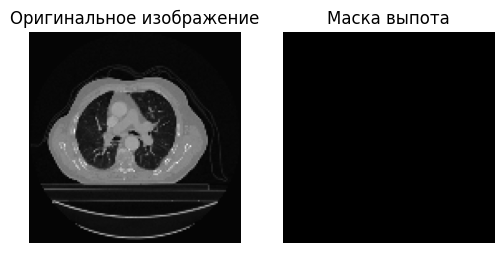

In [ ]:
img_resolution = 128

def get_img_path(dir, i):
    img_dir = get_full_path(os.path.join(dir, batches_train[0][step][i]))               # путь к папке со срезами
    img_path = os.path.join(img_dir,
                            sorted(os.listdir(img_dir))[len(os.listdir(img_dir)) // 2]) # средний срез
    return img_path

# Сформируем numpy для изображения и маски
for i in range(BATCH_SIZE):

    img = get_img_np(get_img_path(original_dir, i), img_resolution)

    if batches_train[1][step][i]: # если есть выпот - получаем его маску
        mask = get_img_np(get_img_path(effusions_dir, i), img_resolution)
        mask_name = 'Есть маска'
    else:                          # если нет - формируем пустое изображение
        mask = np.zeros((img_resolution, img_resolution))
        mask_name = 'Нет маски'

    plot_pics((img, mask), ('Оригинальное изображение', 'Маска выпота'))


###Генерация батчей с данными

In [ ]:
# Функция ограничения значений пикселей в предполагаемых пределах выпота для повышения точности

def apply_bounds(image_3d, image):

    image_hu = image_3d * np.int16(image.RescaleSlope) + np.int16(image.RescaleIntercept)
    image_hu[image_hu>MAX_BOUND] = MAX_BOUND
    image_hu[image_hu<MIN_BOUND] = MIN_BOUND
    image_3d = ((image_hu - np.int16(image.RescaleIntercept))/np.int16(image.RescaleSlope)).astype(np.int16)

    return image_3d


# Функция для получения numpy массива 3D изображений лёгкого

def get_3d_image(path_dir, lungfolder, d_type = np.int16):

        image_3d_np = np.zeros((IMG_RESOLUTION, IMG_RESOLUTION, MAX_SLICES),  # пустой 3D массив
                               dtype = d_type)
        full_path = get_full_path(os.path.join(path_dir, lungfolder))         # путь к папке с изображениями
        slices_count = len(os.listdir(full_path))                             # количество срезов
        
        # Для всех файлов в каталоге по указанному пути:
        for i, filename in enumerate(sorted(os.listdir(full_path))):
            
            # Читаем картинку
            image_path = os.path.join(full_path, filename)
            img_np = get_img_np(image_path)
            
            # Добавляем её в 3D массив
            image_3d_np[:, :, i] = img_np

        if image_path.endswith('dcm'):
            image_3d_np = apply_bounds(image_3d_np, dicom.dcmread(image_path))
        
        return image_3d_np


# Функция загрузки батча изображений из файлов в папке

def batch_generator(step,                                   # шаг обучения
                    set_batches):                           # список из списков батчей директорий с изображениями и списка меток

    x_3d_list = []                                          # список оригинальных изображений набора
    y_3d_list = []                                          # список сегментированных изображений набора

    # Создаём пустые 5D-массивы
    x_batch_np = np.zeros((BATCH_SIZE, IMG_RESOLUTION, IMG_RESOLUTION, MAX_SLICES, 1), dtype = np.int16)
    y_batch_np = np.zeros((BATCH_SIZE, IMG_RESOLUTION, IMG_RESOLUTION, MAX_SLICES, 1), dtype = np.uint8)

    # Для всех директорий в каталоге по указанному пути:
    for i, lung_folder in enumerate(set_batches[0][step]):   # список батча директорий с изображениями

        # Записываем 3D-массив экземпляра в нужный элемент массива image_5d_np
        np.copyto(x_batch_np[i, :, :, :, 0], get_3d_image(original_dir, lung_folder))

        # Если есть выпот - закидываем картинки в 3D изображение
        if set_batches[1][step][i]: # метка выпота
            np.copyto(y_batch_np[i, :, :, :, 0], get_3d_image(effusions_dir, lung_folder, np.uint8))

    # Нормализуем данные батча оригинальных изображений к значениям от 0 до 1
    x_batch_np = (x_batch_np.astype(np.float16) - np.float16(MIN_BOUND)) / (np.float16(MAX_BOUND) - np.float16(MIN_BOUND))

    # Возвращаем батч нормализованных данных 3D изображений
    return (x_batch_np, y_batch_np)

Проверим работу генератора

In [ ]:
# Отметка текущего времени
cur_time = datetime.datetime.now()

# Формируем батч тренировочной выборки
step = 2
batch_step_train = batch_generator(step, batches_train)
print(batch_step_train[0].dtype, batch_step_train[0].shape, batch_step_train[1].shape)

# Получаем время обработки
time_diff = datetime.datetime.now() - cur_time

print('Изображения Оригинальные тренировочные загружены.')
print(f'Время загрузки: {(time_diff.seconds//60)%60} мин {time_diff.seconds%60} с')
print('Метки:', batches_train[1][step])

['LUNG1-005'] [ True] 2 

float16 (1, 32, 32, 304, 1) (1, 32, 32, 304, 1)
Изображения Оригинальные тренировочные загружены.
Время загрузки: 0 мин 2 с
Метки: [ True]


Посмотрим картинки из батча (с выпотом и без). Первые две - оригинальные изображения, вторые - маски к ним.

Для этого в полученных на предыдущем шаге метках должны присутствовать False и True и BATCH_SIZE должен быть больше 1. Если их нет - необходимо изменить параметр step.

In [ ]:
if BATCH_SIZE > 1 and len(np.unique(batches_train[1][step])) > 1:
    print('IMG_RESOLUTION:', IMG_RESOLUTION)

    slice_num = 64  # Номер среза
    idx = []        # Индексы экземпляра с выпотом idx[0] и без idx[1]

    idx.append(np.where(batches_train[1][step])[0])
    idx.append(np.where(~batches_train[1][step])[0])
    images_name = ('Оригинальные изображения', 'Маски')

    for i in range(2):

        # Получаем данные изображений
        img1_np = batch_step_train[i][idx[0][0],:,:,slice_num].squeeze(axis=2)
        img2_np = batch_step_train[i][idx[1][0],:,:,slice_num].squeeze(axis=2)

        # Выводим изображения
        print(images_name[i])
        plot_pics((img1_np, img2_np), ('С выпотом', 'Без выпота'))

На выходе мы имеем готовый батч в виде массивов оригинальных и сегментированных 3D изображений для подачи на обучение.

Формы массивов (4, 512, 512, 297, 1):

(размер батча, ширина картинки, высота картинки, количество срезов, количество каналов).



###Нейронка для сегментации

In [ ]:
#@title Самописная функция ошибки и метрики Dice

def dice_coef(y_true, y_pred, shape=1e-6):
    y_true = K.cast(y_true, dtype='float32') # приводим y_true к типу float32
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    # print(f'y_true= {type(y_true)} y_pred= {type(y_pred)}')
    intersection = K.sum(y_true_f * y_pred_f)
    calc1 = (2. * intersection + shape)
    calc2 =  (K.sum(y_true_f) + K.sum(y_pred_f) + shape)
    res = calc1 / calc2
    return  res

def dice_coef_loss(y_true, y_pred):
    return 1 - dice_coef(y_true, y_pred)

# get_custom_objects().update({"dice_coef": dice_coef, "dice_coef_loss": dice_coef_loss})

In [ ]:
def conv3d_block(input_tensor, num_filters):
    x = Conv3D(num_filters, 3, padding="same")(input_tensor)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    x = Conv3D(num_filters, 3, padding="same")(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)

    return x

def encoder_block(input_tensor, num_filters):
    e_out = conv3d_block(input_tensor, num_filters)
    x = MaxPooling3D(pool_size=(2, 2, 2), strides=(2, 2, 2))(e_out)
    return e_out, x

def decoder_block(input_tensor, skip_tensor, num_filters):
    x = Conv3DTranspose(num_filters, kernel_size=(2, 2, 2), strides=(2, 2, 2), padding="same")(input_tensor)
    x = concatenate([x, skip_tensor], axis=-1)
    x = conv3d_block(x, num_filters)
    return x

def unet_3d(input_shape, num_classes):
    inputs = Input(input_shape)

    # Encoder
    e_out1, e1 = encoder_block(inputs, 64)
    e_out2, e2 = encoder_block(e1, 128)
    e_out3, e3 = encoder_block(e2, 256)
    e_out4, e4 = encoder_block(e3, 512)

    # Bridge
    b1 = conv3d_block(e4, 1024)

    # Decoder
    d1 = decoder_block(b1, e_out4, 512)
    d2 = decoder_block(d1, e_out3, 256)
    d3 = decoder_block(d2, e_out2, 128)
    d4 = decoder_block(d3, e_out1, 64)

    # Output
    outputs = Conv3D(num_classes, 1, activation="sigmoid", padding="same")(d4)

    model = Model(inputs, outputs)
    return model

In [ ]:
input_shape = (IMG_RESOLUTION, IMG_RESOLUTION, MAX_SLICES, 1)

model_unet_3d = unet_3d(input_shape, CLASS_COUNT)
model_unet_3d.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 304  0           []                               
                                , 1)]                                                             
                                                                                                  
 conv3d_19 (Conv3D)             (None, 32, 32, 304,  1792        ['input_2[0][0]']                
                                 64)                                                              
                                                                                                  
 batch_normalization_18 (BatchN  (None, 32, 32, 304,  256        ['conv3d_19[0][0]']              
 ormalization)                   64)                                                        

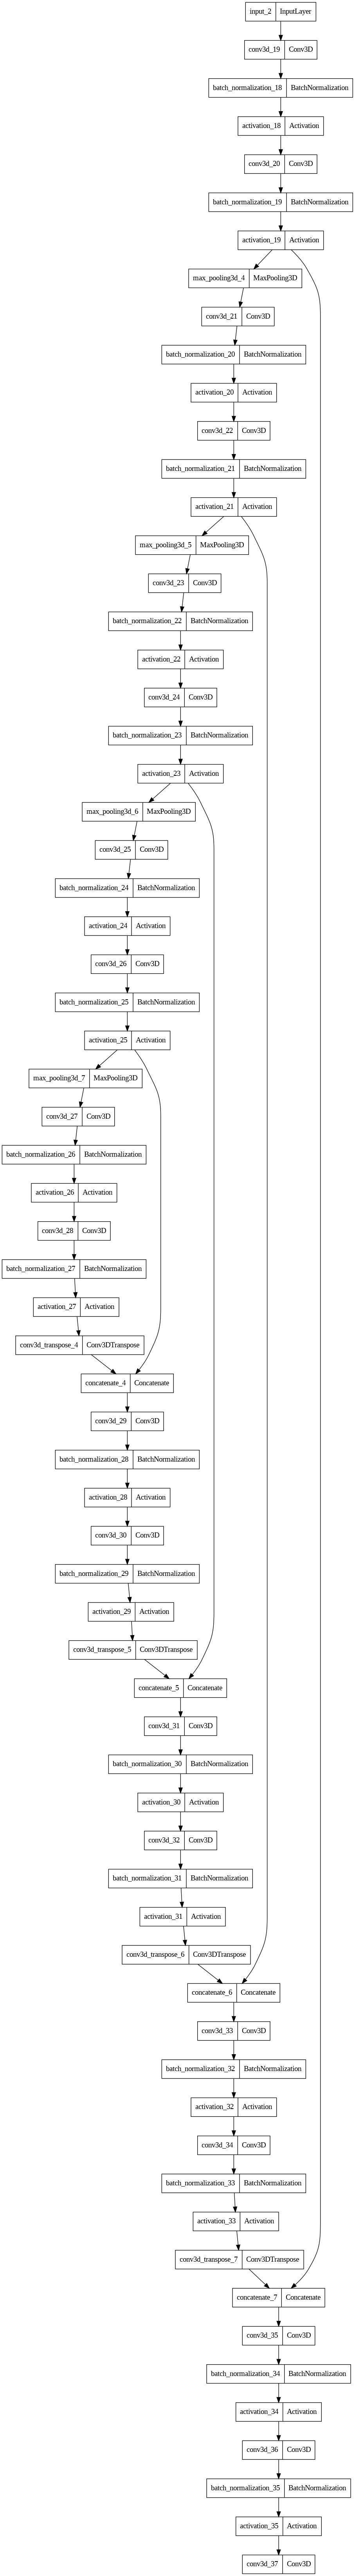

In [ ]:
# Выводим схему модели

plot_model(model_unet_3d)

In [ ]:
# Компилируем модель

model_unet_3d.compile(optimizer=Adam(learning_rate=1e-4), loss=dice_coef_loss, metrics=[dice_coef])

In [ ]:
def print_log(current,                           # номер текущего батча
              amount,                            # число всех батчей 
              params):                           # словарь дополнительных параметров для вывода 
  
  bar_len = 20                                   # Длина бара 
  percent = int(current * bar_len / amount)      # Процент выполненной работы
  progressbar = ''

  for i in range(bar_len):                       #Проходим по всем элементам прогрессбара и добавляем символы в соответствии с прогрессом 
    if(i < percent):
      progressbar += '='
    elif(i == percent):
      progressbar += '>'
    else:
      progressbar += '-'

  # Добавляем в финальное сообщение символ переноса каретки консоли на начальную строку, добавляем информацию о номере батча
  # количестве всех батчей, прогрессбар
  # Символ переноса коретки \r добавляется для того, чтобы каждый новый батч перезаписывать вывод. Таким образом вывод не будет засоряться повторяющейся информацией
  message = "\r" + str(current) + '/' + str(amount) + ' [' + progressbar + ']  ' 
 
                                                # Добавляем дополнительные параметры в вывод
  for key in params:
    message += key + ': ' + str(params[key]) + '. '
  
  print(message, end='')

In [ ]:
def model_train_on_batch(model, epochs=50):

    # создаём пустые списки для сбора усредненных данных от шагов в конце эпохи
    loss_train_lrn =[]
    acc_train_lrn =[]
    loss_val_lrn =[]
    acc_val_lrn =[]

    # определяем количество шагов
    steps_train = len(batches_train[0])
    steps_val = len(batches_val[0])

    for epoch in range(epochs):                                                   # запускаем цикл обучения по эпохам
        int_start = datetime.datetime.now()                                       # записываем начальное время эпохи
        
        # создаем пустые списки для сбора данных по шагам внутри эпохи
        loss_train = []    
        acc_train = []
        loss_val = []
        acc_val = []

        print('Эпоха', epoch , '/', epochs)                                       # Выводим текущую эпоху и общее число эпох

        # запускаем цикл обучения по шагам внутри эпохи
        for step in range(steps_train):                                           # получаем батч данных для обучения
            
            train_step_data = batch_generator(step, batches_train)
            # пропускаем обучающий батч данных, получаем ошибку и точность как список
            result_train_step = model.train_on_batch(train_step_data[0], train_step_data[1])
            
            loss_train.append(result_train_step[0])                               # собираем ошибку на шаге
            acc_train.append(result_train_step[1])                                # собираем точность на шаге

            # Задаем параметры в словаре, которые будем выводить

            time_diff = datetime.datetime.now() - cur_time                        # Получаем время обработки
            params = {'Время(сек.) на эпохе': time_diff.seconds,#round(time.time() - int_start,2), # считаем время обучения на данной эпохе и добавляем в словарь
                      'loss': round(result_train_step[0], 4),                   # добавляем в словарь ошибку на шаге обучения
                      'accuracy': round(result_train_step[1], 4)}                    # добавляем точность на шаге обучения

            # печатаем отдельной функцией текущие данные на шаге обучения
            print_log(step, steps_train, params)                                  # выводим всю нужную информацию 
            # запоминаем последний шаг обучения на эпохе
            # и добавляем единицу для корректности отображения
            endstep = step+1 
        
          
        # собираем усредненные ошибку и точность на обучении от всех шагов на эпохе
        loss_train_lrn.append(np.mean(loss_train))
        acc_train_lrn.append(np.mean(acc_train))

        # запоминаем и округляем последнее записанное усредненное значение для отображения по ходу обучения
        params['loss'] =  round(loss_train_lrn[-1],4)                           # перезаписываем в словаре для ошибки на обучении
        params['accuracy'] =  round(acc_train_lrn[-1],4)                             # перезаписываем в словаре для точности на обучении
        
        # оцениваем модели на проверочной базе
        for step in range(steps_val):
            # получаем батч данных для проверки
            val_step_data = batch_generator(step, batches_val)
            # пропускаем проверочный батч данных через функцию оценки модели,
            # получаем ошибку и точность как список
            result_val_step = model.evaluate(val_step_data[0], val_step_data[1], verbose=0)
            # собираем ошибку на шаге
            loss_val.append(result_val_step[0])
            # собираем точность на шаге
            acc_val.append(result_val_step[1])

        # собираем усредненные ошибку и точность на проверке от всех шагов на эпохе
        loss_val_lrn.append(np.mean(loss_val))
        acc_val_lrn.append(np.mean(acc_val))
        
        # запоминаем и округляем последнее записанное значение для отображения по ходу обучения
        val_parm = {'val_loss': round(loss_val_lrn[-1],4),                    # добавляем в словарь  
                    'val_accuracy': round(acc_val_lrn[-1],4)}                 # добавляем точность в словарь
        # добавляем в обший словарь параметров по эпохе словарь с оценкой модели
        params.update(val_parm)
        # печатаем отдельной функцией усредненные данные в конце текущей эпохи обучения
        print_log(endstep, steps_train, params)                                 # выводим всю нужную информацию 
            
        # Вручную переносим каретку на следующую строку,
        # чтобы не стирать финальные значения сети на эпохе
        print()

        model_history = {'loss': loss_train_lrn,
                         'val_loss': loss_val_lrn,
                         'accuracy': acc_train_lrn,
                         'val_accuracy': acc_val_lrn}

    return model_history

In [ ]:
print('IMG_RESOLUTION =', IMG_RESOLUTION)
print('BATCH_SIZE =', BATCH_SIZE)

# Обучаем модель на батчах
model_train_on_batch(model_unet_3d, 10)

IMG_RESOLUTION = 32
BATCH_SIZE = 1
Эпоха 0 / 10
['LUNG1-002'] [ True] 0 

